# NLP: Yelp Review to Rating
## :)

In [1]:
# usual libs

import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLP lib
import nltk


# importing torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1) #for reproducibility

In [2]:
yelp = pd.read_json("./yelp_review_training_dataset.jsonl", lines = True)
yelp.head()

,review_id,text,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1


In [3]:
rev_len = yelp['text'].apply(len)
yelp.insert(2, "length", rev_len, True)
yelp.head()

,review_id,text,length,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,204,1
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,1561,5
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,615,5
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,407,5
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,3509,1


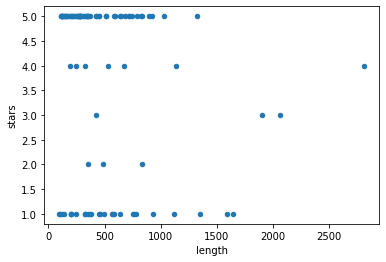

In [4]:
random_plot = yelp.sample(100)
random_plot.plot.scatter(x = 'length', y = 'stars')

ok so length means nothing really, but it looks like there is a bit of a class imbalance as demonstrated by the visualization below

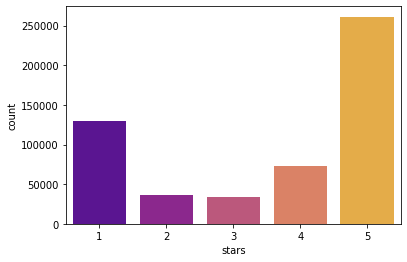

In [8]:
sns.countplot(yelp['stars'], palette = 'plasma')

/home/tanvee/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


stars
1    741.227506
2    701.123013
3    612.270058
4    523.488388
5    449.517560
Name: length, dtype: float64

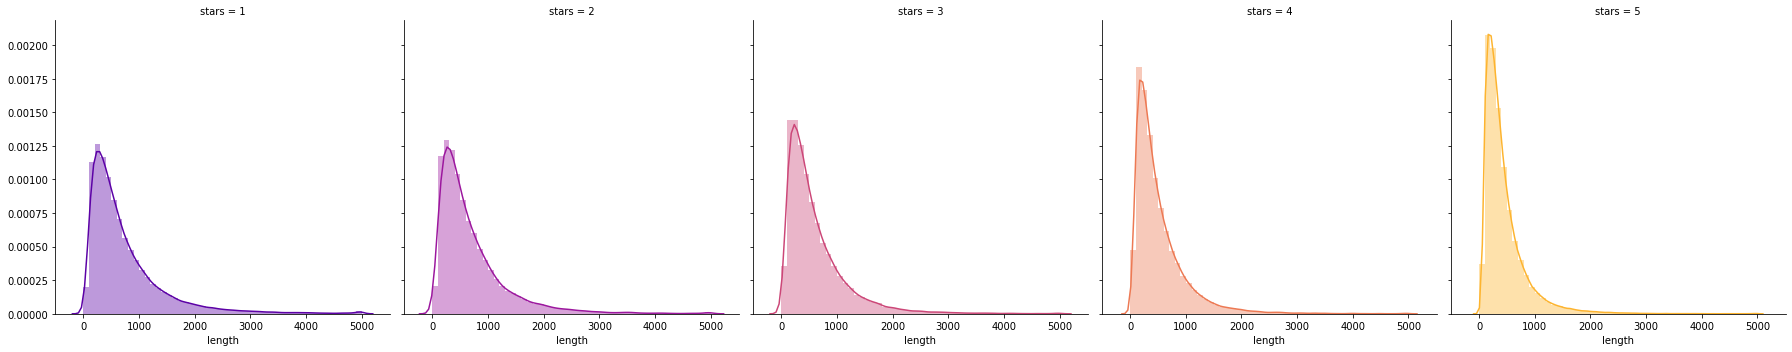

In [9]:
a = sns.FacetGrid(data = yelp, col = 'stars', hue = 'stars', palette='plasma', size=5)
a.map(sns.distplot, "length")
yelp.groupby('stars').mean()['length']

interesting...